<div style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px; color: #bbb">
<h2> Описание проекта: <a class="tocSkip"></a> </h2>
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.
</div>

# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
try:
    real_age = pd.read_csv('/datasets/faces/labels.csv')
except:
    real_age = pd.read_csv('https://code.s3.yandex.net/datasets/faces/labels.csv')

In [3]:
print(f'Полных дубликатов: {real_age.duplicated().sum()}\n')
print(f'Пропуски:\n{real_age.isna().sum()}\n')
print(f'Общие сведения:\n{real_age.describe()}\n')
print(f'Беглый просмотр:\n{real_age}\n')

Полных дубликатов: 0

Пропуски:
file_name    0
real_age     0
dtype: int64

Общие сведения:
          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000

Беглый просмотр:
       file_name  real_age
0     000000.jpg         4
1     000001.jpg        18
2     000002.jpg        80
3     000003.jpg        50
4     000004.jpg        17
...          ...       ...
7586  007608.jpg        14
7587  007609.jpg        37
7588  007610.jpg        28
7589  007611.jpg        20
7590  007612.jpg        47

[7591 rows x 2 columns]



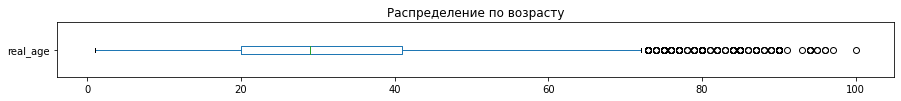

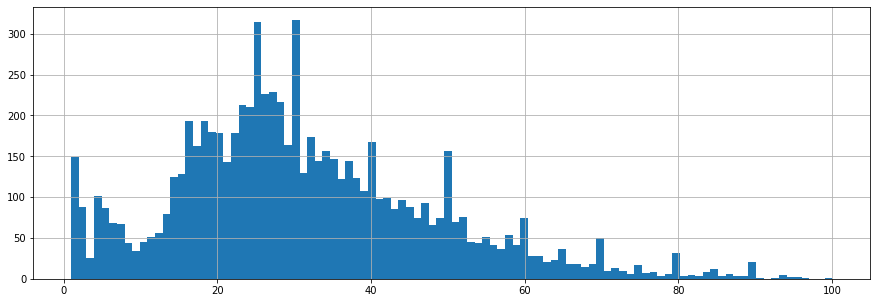

In [4]:
import matplotlib.pyplot as plt
real_age.real_age.plot.box(title='Распределение по возрасту', vert=False, figsize=(15,1))
plt.show()
real_age.real_age.hist(bins=100, figsize=(15,5));

In [5]:
batch_size=15
datagen = ImageDataGenerator(rescale=1./255.,
        # аугментация:
        #horizontal_flip=True, # отражение по горизонтали
        #vertical_flip=True, # отражение по вертикали
        #rotation_range=90, # повороты
        #width_shift_range=0.2, # сдвиг по ширине
        #height_shift_range=0.2  # сдвиг по высоте
                            )
gen_flow = datagen.flow_from_dataframe(
        dataframe=real_age,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='raw',
        seed=1)

Found 7591 validated image filenames.


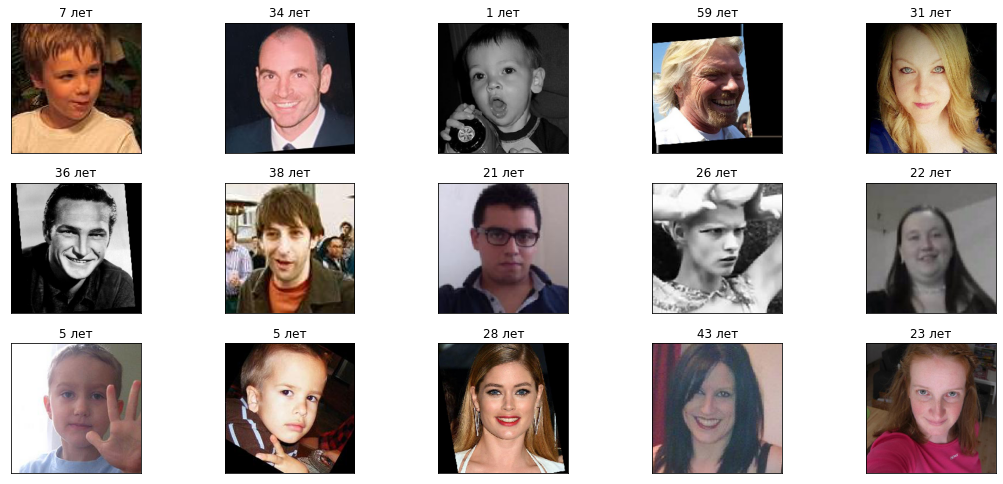

In [6]:
features, target = next(gen_flow)

fig = plt.figure(figsize=(15, 3 * batch_size // 5))
for i in range(batch_size):
    fig.add_subplot((batch_size // 5) + 1, 5, i+1)
    plt.imshow(features[i])
    plt.title(str(target[i]) + ' лет')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

1. В датасете 7591 цветных изображений, которые были приведены к размеру 224\*224.
2. Медианный возраст людей в датасете 29 лет. Для части фотографий характерно округление возраста до 5 лет.
3. Ящик с усами показывает, что люди с возрастом больше ~72 лет находятся в зоне выброса. Скорее всего, возраст пожилых людей будет определяться с большой погрешностью.
4. При выводе случайных изображений были замечены следующие закономерности/особенности:
    * присутствуют как цветные, так и ч/б изображения
    * на части фотокрафий часть снимков смазана
    * присутствуют люди в полный рост
    * Присутствуют снимки без людей
    * На большинстве фотографий лицо находится по центру кадра
5. Чтобы улучшить качество предсказаний можно добваить зеркальные отражения, добавить фотографии, повернутые на определенный угол и незначительно сдвинутые от центра фотографии.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D#, Dropout, Conv2D, Flatten, AvgPool2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

param={'batchs':50, 'adam':0.5, 'epochs':15, 'seed':17}

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.20,
        # аугментация:
        horizontal_flip=True, # отражение по горизонтали
        #vertical_flip=True, # отражение по вертикали
        rotation_range=90, # повороты
        width_shift_range=0.2, # сдвиг по ширине
        height_shift_range=0.2, # сдвиг по высоте
        rescale=1./255.)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=param['batchs'],
        class_mode='raw',
        subset='training',
        seed=param['seed'])
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.20,
        rescale=1./255.)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=param['batchs'],
        class_mode='raw',
        subset='validation',
        seed=param['seed'])
    return train_gen_flow

def create_model(input_shape):
    optimizer = Adam(lr = 0.0001 * param['adam'])
    backbone = ResNet50(
        #weights='imagenet',
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        input_shape=input_shape,
        include_top=False)
    backbone.trainable = True
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
#    model.add(Dense(29, activation='relu'))
#    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=param['epochs'],
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None: steps_per_epoch = len(train_data)
    if validation_steps is None: validation_steps = len(test_data)
    model.fit(train_data, validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
```

```
Found 6073 validated image filenames.
Found 1518 validated image filenames.
Train for 122 steps, validate for 31 steps
Epoch 1/15
122/122 - 120s - loss: 478.9282 - mae: 16.5519 - val_loss: 325.6657 - val_mae: 14.8174
Epoch 2/15
122/122 - 95s - loss: 148.2135 - mae: 9.2459 - val_loss: 464.4058 - val_mae: 16.2350
Epoch 3/15
122/122 - 95s - loss: 122.4794 - mae: 8.4455 - val_loss: 444.8796 - val_mae: 15.7792
Epoch 4/15
122/122 - 95s - loss: 110.1464 - mae: 8.0580 - val_loss: 587.8434 - val_mae: 18.9366
Epoch 5/15
122/122 - 95s - loss: 100.5906 - mae: 7.6669 - val_loss: 284.5615 - val_mae: 12.5345
Epoch 6/15
122/122 - 95s - loss: 92.8065 - mae: 7.3901 - val_loss: 188.0555 - val_mae: 10.1102
Epoch 7/15
122/122 - 95s - loss: 89.7395 - mae: 7.2268 - val_loss: 118.5430 - val_mae: 8.2397
Epoch 8/15
Epoch 9/15
122/122 - 95s - loss: 80.4272 - mae: 6.8855 - val_loss: 108.2304 - val_mae: 7.6657
122/122 - 95s - loss: 74.7703 - mae: 6.6958 - val_loss: 97.4302 - val_mae: 7.4467
Epoch 10/15
122/122 - 95s - loss: 71.7148 - mae: 6.5339 - val_loss: 91.0149 - val_mae: 7.2076
Epoch 11/15
122/122 - 95s - loss: 66.6351 - mae: 6.3146 - val_loss: 121.3022 - val_mae: 8.2226
Epoch 12/15
122/122 - 95s - loss: 65.2743 - mae: 6.2776 - val_loss: 116.0273 - val_mae: 7.9865
Epoch 13/15
122/122 - 95s - loss: 59.6615 - mae: 5.9965 - val_loss: 82.6761 - val_mae: 6.7486
Epoch 14/15
122/122 - 95s - loss: 57.2981 - mae: 5.8615 - val_loss: 88.3972 - val_mae: 7.0325
Epoch 15/15
122/122 - 95s - loss: 54.6614 - mae: 5.7176 - val_loss: 86.4370 - val_mae: 6.8561
31/31 - 8s - loss: 86.4370 - mae: 6.8561
Test MAE: 6.8561
```

## Анализ обученной модели

Средняя ошибка определения возраста не превосходит 7 лет (порог для успешности алгоритма 8 лет). Наблюдается назначительно переобучение модели, но в пределах допустимого. Результаты мало зависят от добавления промежуточных полносвязных слоев (после модели ResNet50), поэтому в итоговой версии они были удалены как избыточные.

   
Достигнутый результат позволит достичь только части поставленной бизнесом задач:
    
* Не получится эффективно проверять совершеннолетие покупающих алкоголь посетителей, соответственно и контролировать продавцов
* По фотографиям возможно классифицировать возрастные группы. На основе этого можно анализировать покупки/предлагать товары, которые могут заинтересовать покупателей этой возрастной группы. Но даже это возможно только режиме сбора статистики с последующей пост-обработкой маркетологами/аналитиками.
* Текущее биораспознование в системах СКУД-а подразумевает последовательное пропускание видеопотока через 2 сервера. На первом этапе видеопоток делится на кадры, и выбирается кадр с лучшим ракурсом. И только эта лучшая фотография подается на сервер распознавания. Предъявляемые мощности к первому этапу на порядок выше тех, которые нужны для второго этапа распознавания. Это следует учитывать при планировании внедрения системы (плюс затраты на повышения пропускной способности сети предприятия, т.к. несколько видеопотоков могут положить сеть при неправильной конфигурации сети)